In [1]:
!pip install geocoder lightgbm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np

from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import geocoder


In [3]:
class Config:
    train_path = "../input/train_v2.csv"
    test_path = "../input/test_v2.csv"
    sample_submission_path = "../input/sample_submission.csv"
    output_path = "../submission/"
    seed = 42
    n_splits = 2



In [4]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)


In [5]:
# 参考
# https://comp.probspace.com/competitions/pollen_counts/discussions/kotrying-Post833da695e2f337e5a86f


import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



In [6]:
df_train[df_train["pollen_utsunomiya"] < 0 ].head()

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
199,2017020908,0.0,0.0,0.0,0.3,2.2,1.0,16,15,1,3.1,3.6,1.2,-9996.0,0.0,344.0
200,2017020909,0.0,0.0,0.0,-0.3,2.8,1.8,1,15,1,4.2,2.9,0.8,-9996.0,0.0,4.0
201,2017020910,0.5,0.0,0.0,0.2,3.1,2.3,1,15,1,3.4,3.1,1.7,-9998.0,0.0,8.0
205,2017020914,0.5,0.5,0.5,1.5,3.4,1.5,16,15,15,4.2,2.2,0.8,-9998.0,0.0,-9998.0
208,2017020917,0.5,1.0,1.0,1.4,2.0,0.6,1,15,14,4.5,3.6,1.3,-9998.0,-9998.0,-9998.0


In [7]:
# https://comp.probspace.com/competitions/pollen_counts/discussions/tanuking0-Post352b748b3b6d376b837e
#＊ 花粉飛散量に関する補足 (2022/11/15追記)
# 空白, -9996,-9997,-9998については下記を表しています
# -9998:降雪による欠測
# -9997:黄砂による欠測
# -9996:その他の欠測(前後の時間や周辺観測値と比較して不自然なデータ)
# 空白:未観測または通信障害による欠測


#df_train.loc[df_train["pollen_utsunomiya"] < 0, "pollen_utsunomiya"] = '欠測'
#df_train.loc[df_train["pollen_chiba"] < 0, "pollen_chiba"] = '欠測'
#df_train.loc[df_train["pollen_tokyo"] < 0, "pollen_tokyo"] = '欠測'

#df_train.loc[df_train["pollen_utsunomiya"] < 0, "pollen_utsunomiya"] = 0
#df_train.loc[df_train["pollen_chiba"] < 0, "pollen_chiba"] = 0
#df_train.loc[df_train["pollen_tokyo"] < 0, "pollen_tokyo"] = 0

# 雪は花粉０そうなので0
df_train.loc[df_train["pollen_utsunomiya"] == -9998, "pollen_utsunomiya"] = 0
df_train.loc[df_train["pollen_chiba"] == -9998, "pollen_chiba"] = 0
df_train.loc[df_train["pollen_tokyo"] == -9998, "pollen_tokyo"] = 0

# 黄砂は花粉飛びそうだがいったん 0
#df_train.loc[df_train["pollen_utsunomiya"] == -9997, "pollen_utsunomiya"] = '欠測'
#df_train.loc[df_train["pollen_chiba"] == -9997, "pollen_chiba"] = '欠測'
#df_train.loc[df_train["pollen_tokyo"] == -9997, "pollen_tokyo"] = '欠測'

# -9996 は削除、後段で実施
# 空白はたぶんない

In [8]:
df_train = df_train.replace("欠測", np.nan)
lgb_imp = IterativeImputer(
    estimator=LGBMRegressor(num_boost_round=1000, random_state=Config.seed),
    max_iter=10,
    initial_strategy="mean",
    imputation_order="ascending",
    verbose=1,
    random_state=Config.seed,
)

df_train = pd.DataFrame(lgb_imp.fit_transform(df_train), columns=df_train.columns)


[IterativeImputer] Completing matrix with shape (12240, 16)
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec

[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[IterativeImputer] Change: 10.411119595392345, scaled tolerance: 2020033.124 
[IterativeImputer] Early stopping criterion reached.


In [9]:
df_train[df_train["pollen_utsunomiya"] < 0 ].head()

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
199,2.017021e+09,0.0,0.0,0.0,0.3,2.2,1.0,16.0,15.0,1.0,3.1,3.6,1.2,-9996.0,0.0,344.0
200,2.017021e+09,0.0,0.0,0.0,-0.3,2.8,1.8,1.0,15.0,1.0,4.2,2.9,0.8,-9996.0,0.0,4.0


In [10]:
# 型がfloatになってしまっているので、もどす。
df_train[["winddirection_chiba", "winddirection_tokyo"]] = (
    df_train[["winddirection_chiba", "winddirection_tokyo"]].round().astype(int)
)
df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
] = df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
].round(
    1
)
df_train["datetime"] = df_train["datetime"].astype(int)

# df_train[df_train.select_dtypes(object).columns] = df_train[df_train.select_dtypes(object).columns]
df_train.head(3)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16.0,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1.0,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1.0,15,16,4.0,1.7,0.6,4.0,32.0,12.0


In [11]:
loc_list = ["宇都宮市中央生涯学習センター", "千葉県環境研究センター", "東京都多摩小平保健所"]

utsunomiya = "utsunomiya"
chiba = "chiba"
tokyo = "tokyo"

key_list = [utsunomiya, chiba, tokyo]

LATLNG_DICT = {}

try:

    for i, key in zip(loc_list, key_list):
        loc = geocoder.osm(i, timeout=5.0)
        print(loc.latlng)
        print(loc.address)
        LATLNG_DICT[key] = tuple(loc.latlng)

    LOC_VECTOR_DICT = {
        (utsunomiya, tokyo): np.array(LATLNG_DICT[utsunomiya])
        - np.array(LATLNG_DICT[tokyo]),
        (utsunomiya, chiba): np.array(LATLNG_DICT[utsunomiya])
        - np.array(LATLNG_DICT[chiba]),
        (chiba, tokyo): np.array(LATLNG_DICT[chiba]) - np.array(LATLNG_DICT[tokyo]),
        (chiba, utsunomiya): np.array(LATLNG_DICT[chiba])
        - np.array(LATLNG_DICT[utsunomiya]),
        (tokyo, chiba): np.array(LATLNG_DICT[tokyo]) - np.array(LATLNG_DICT[chiba]),
        (tokyo, utsunomiya): np.array(LATLNG_DICT[tokyo])
        - np.array(LATLNG_DICT[utsunomiya]),
    }

    print(LATLNG_DICT)
    print(LOC_VECTOR_DICT)

except Exception as e:
    print(e)
    print("APIでのデータ取得に失敗したため、成功時に取得したデータを使います。")
    LATLNG_DICT = {
        "utsunomiya": (36.5594462, 139.88265145),
        "chiba": (35.633642, 140.077749),
        "tokyo": (35.7298652, 139.51664115548698),
    }
    LOC_VECTOR_DICT = {
        ("utsunomiya", "tokyo"): np.array([0.829581, 0.36601029]),
        ("utsunomiya", "chiba"): np.array([0.9258042, -0.19509755]),
        ("chiba", "tokyo"): np.array([-0.0962232, 0.56110784]),
        ("chiba", "utsunomiya"): np.array([-0.9258042, 0.19509755]),
        ("tokyo", "chiba"): np.array([0.0962232, -0.56110784]),
        ("tokyo", "utsunomiya"): np.array([-0.829581, -0.36601029]),
    }


output = """
[36.5594462, 139.88265145]
宇都宮市 中央生涯学習センター, 中央通り, 中央一丁目, 宇都宮市, 栃木県, 320-0802, 日本
[35.633642, 140.077749]
千葉県環境研究センター, 海浜松風通り, 高浜五丁目, 美浜区, 千葉市, 千葉県, 261-0004, 日本
[35.7298652, 139.51664115548698]
東京都多摩小平保健所, 青梅街道, 芝久保町, 小平市, 東京都, 188-0014, 日本
{'utsunomiya': (36.5594462, 139.88265145), 'chiba': (35.633642, 140.077749), 'tokyo': (35.7298652, 139.51664115548698)}
{('utsunomiya', 'tokyo'): array([0.829581  , 0.36601029]), ('utsunomiya', 'chiba'): array([ 0.9258042 , -0.19509755]), ('chiba', 'tokyo'): array([-0.0962232 ,  0.56110784]), ('chiba', 'utsunomiya'): array([-0.9258042 ,  0.19509755]), ('tokyo', 'chiba'): array([ 0.0962232 , -0.56110784]), ('tokyo', 'utsunomiya'): array([-0.829581  , -0.36601029])}
"""



[36.5594462, 139.88265145]
宇都宮市 中央生涯学習センター, 中央通り, 中央一丁目, 宇都宮市, 栃木県, 320-0802, 日本
[35.633642, 140.077749]
千葉県環境研究センター, 海浜松風通り, 高浜五丁目, 美浜区, 千葉市, 千葉県, 261-0004, 日本
[35.7298652, 139.51664115548698]
東京都多摩小平保健所, 青梅街道, 芝久保町, 小平市, 東京都, 188-0014, 日本
{'utsunomiya': (36.5594462, 139.88265145), 'chiba': (35.633642, 140.077749), 'tokyo': (35.7298652, 139.51664115548698)}
{('utsunomiya', 'tokyo'): array([0.829581  , 0.36601029]), ('utsunomiya', 'chiba'): array([ 0.9258042 , -0.19509755]), ('chiba', 'tokyo'): array([-0.0962232 ,  0.56110784]), ('chiba', 'utsunomiya'): array([-0.9258042 ,  0.19509755]), ('tokyo', 'chiba'): array([ 0.0962232 , -0.56110784]), ('tokyo', 'utsunomiya'): array([-0.829581  , -0.36601029])}


# Feature

In [12]:
import datetime
import re

# 時間
def to_datetime(time: datetime.datetime) -> datetime.datetime:
    time = str(time)
    try:
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
    except ValueError:
        time = re.sub("24$", "23", time)
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
        time += datetime.timedelta(hours=1)
    return time


def time_feat(df: pd.DataFrame) -> pd.DataFrame:
    df["datetime_dt"] = df["datetime"].apply(to_datetime)
    df["year"] = df["datetime_dt"].dt.year
    df["month"] = df["datetime_dt"].dt.month
    df["day"] = df["datetime_dt"].dt.day
    df["hour"] = df["datetime_dt"].dt.hour
    df["hour_sin"] = np.sin(df["datetime_dt"].dt.hour * (2 * np.pi / (24 + 1)))
    df["hour_cos"] = np.cos(df["datetime_dt"].dt.hour * (2 * np.pi / (24 + 1)))
    df["weekday"] = df["datetime_dt"].dt.weekday
    df["day_of_year"] = df["datetime_dt"].dt.dayofyear
    df["day_sin"] = np.sin(df["day_of_year"] * (2 * np.pi / (365 + 1)))
    df["day_cos"] = np.cos(df["day_of_year"] * (2 * np.pi / (365 + 1)))
    
    df["day_sin_mulit_hour_sin"] = df["hour_sin"] * df["day_sin"] 
    df["day_sin_mulit_hour_cos"] = df["hour_cos"] * df["day_cos"]
    
    df["day_sin_sum_hour_sin"] = df["hour_sin"] + df["day_sin"] 
    df["day_sin_sum_hour_cos"] = df["hour_cos"] + df["day_cos"]

    df["day_sin_mulit_hour_sin_mult_month"] = df["hour_sin"] * df["day_sin"] * (df["month"] / 12)
    df["day_sin_mulit_hour_cos_mult_month"] = df["hour_cos"] * df["day_cos"] * (df["month"] / 12)
    
    df["day_sin_sum_hour_sin_mult_month"] = df["hour_sin"] + df["day_sin"] * (df["month"] / 12)
    df["day_sin_sum_hour_cos_mult_month"] = df["hour_cos"] + df["day_cos"] * (df["month"] / 12)

    return df


# ラグ特徴/ローリング特徴量
def add_lag_feat(df: pd.DataFrame, feat: List[str], group: str) -> pd.DataFrame:
    outputs = [df]

    grp_df = df.groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    for lag in [1, 2, 3, 4, 5]:
        # shift
        outputs.append(grp_df[feat].shift(lag).add_prefix(f"shift{lag}_"))
        # diff
        outputs.append(grp_df[feat].diff(lag).add_prefix(f"diff{lag}_"))

    # rolling
    windows = [3] + [i * 24 for i in range(1, 10)]
    for window in windows:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"rolling{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True))

    _df = pd.concat(outputs, axis=1)
    return _df


# 未来のローリング -> 下がったのでなし
# https://www.slideshare.net/TakanoriHayashi3/talkingdata-adtracking-fraud-detection-challenge-1st-place-solution
def add_future_lag_feat(df: pd.DataFrame, feat: List[str], group: str) -> pd.DataFrame:
    outputs = [df]
    grp_df = df.iloc[::-1].groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    for window in [3, 24]:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"future_rolling{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True))
    return pd.concat(outputs, axis=1)


def add_lag_feat_one_year(df: pd.DataFrame, feat: List[str]) -> pd.DataFrame:
    outputs = [df]
    prefix = "shift_one_year_"
    outputs.append(df[feat].shift(365 // 2).add_prefix(prefix))

    df = pd.concat(outputs, axis=1)
    outputs = [df]
    cols = [f"{prefix}{col}" for col in feat]
    
    for window in [3] + [i * 24 for i in range(1, 10)]:
        outputs.append(
            df[cols].rolling(window, min_periods=1).mean().add_prefix(f"roll_{window}_")
        )

    df = pd.concat(outputs, axis=1)
    return df


# 集計特徴
def additional_encoding(
    train: pd.DataFrame, test: pd.DataFrame, cat_col: List[str], num_col: List[str]
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    trdf = train.copy()
    tedf = test.copy()

    # Count Encoding
    for ccol in cat_col:
        encoder = trdf[(trdf["month"] == 4) & (trdf["day"] < 15)][ccol].value_counts()
        trdf[f"ce_{ccol}"] = trdf[ccol].map(encoder)
        tedf[f"ce_{ccol}"] = tedf[ccol].map(encoder)

    # Add Aggregate Features
    agg_cols = ["mean", "std", "min", "max"]
    for ccol in cat_col:
        for ncol in num_col:
            agg_df = trdf.groupby(ccol)[ncol].agg(agg_cols)
            agg_df["abs_mean"] = np.abs(agg_df["mean"])
            agg_df["min_max"] = agg_df["min"] * agg_df["max"]
            agg_df.columns = [f"{ccol}_{c}" for c in agg_df.columns]
            trdf = trdf.merge(agg_df, on=ccol, how="left")
            tedf = tedf.merge(agg_df, on=ccol, how="left")

    return trdf, tedf


def add_wind_direction_one_hot(df: pd.DataFrame) -> pd.DataFrame:

    cols = [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]

    num_wind_direction = 17

    dfs = []
    for col in cols:
        data = {f"{col}_{i}": [] for i in range(num_wind_direction)}
        for x in df[col].astype(int):
            for i in range(num_wind_direction):
                if x == i:
                    data[f"{col}_{i}"].append(1)
                else:
                    data[f"{col}_{i}"].append(0)

        _df = pd.DataFrame(data)
        dfs.append(_df)

    return pd.concat([df] + dfs, axis=1)


def add_wind_direction_to_cos_sin(df: pd.DataFrame) -> pd.DataFrame:
    """
    {col} が 0：静穏 の場合 {col}_cos, {col}_sinには、欠損になる
    1：北北東
    2：北東
    3：東北東
    4：東
    5：東南東
    6：南東
    7：南南東
    8：南
    9：南南西
    10：南西
    11：西南西
    12：西
    13：西北西
    14：北西
    15：北北西
    16：北
    
    """
    df_origin = df.copy()

    direction_map = {
        1: 13,
        2: 14,
        3: 15,
        4: 0,
        5: 1,
        6: 2,
        7: 3,
        8: 4,
        9: 5,
        10: 6,
        11: 7,
        12: 8,
        13: 9,
        14: 10,
        15: 11,
        16: 12,
    }

    pref_list = [utsunomiya, tokyo, chiba]

    for col in [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]:

        _df = df_origin[[col]].copy()
        _df = _df.reset_index()
        _df = _df[_df[col] != 0].reset_index(drop=True)  # 0：静穏 は風の方向ではないので消す
        # _df[col] = _df[col] - 1  # 1 ~ 16 なので 0 ~ 15に変換
        _df[col] = _df[col].apply(lambda x: direction_map[x])

        _df[f"{col}_cos"] = np.cos(2 * np.pi * _df[col] / (_df[col].max() + 1))
        _df[f"{col}_sin"] = np.sin(2 * np.pi * _df[col] / (_df[col].max() + 1))
        _df = _df.drop(col, axis=1)

        target_pref = col.split("_")[1]
        other_pref = list(set(pref_list) - set([target_pref]))

        # 内積 window directionベクトル と 他県へのベクトル
        _df[f"{col}_ip_wind_loc_{other_pref[0]}"] = (
            _df[f"{col}_cos"] * LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
            + _df[f"{col}_sin"] * LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
        )

        _df[f"{col}_ip_wind_loc_{other_pref[1]}"] = (
            _df[f"{col}_cos"] * LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
            + _df[f"{col}_sin"] * LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
        )

        # なす角のcos/arc cos  window directionベクトル と 他県へのベクトル
        _df[f"{col}_cos_wind_loc_{other_pref[0]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[0]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
                * LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
                + LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
                * LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
            )
        )

        _df[f"{col}_arc_cos_wind_loc_{other_pref[0]}"] = (
            _df[f"{col}_ip_wind_loc_{other_pref[0]}"]
            / (
                (
                    np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                    + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
                )
                * (
                    LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
                    * LOC_VECTOR_DICT[(other_pref[0], target_pref)][1]
                    + LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
                    * LOC_VECTOR_DICT[(other_pref[0], target_pref)][0]
                )
            )
        ).apply(lambda x: np.degrees(np.arccos(x)))

        _df[f"{col}_cos_wind_loc_{other_pref[1]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[1]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
                * LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
                + LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
                * LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
            )
        )

        _df[f"{col}_arc_cos_wind_loc_{other_pref[1]}"] = _df[
            f"{col}_ip_wind_loc_{other_pref[1]}"
        ] / (
            (
                np.sqrt(_df[f"{col}_cos"] * _df[f"{col}_cos"])
                + np.sqrt(_df[f"{col}_sin"] * _df[f"{col}_sin"])
            )
            * (
                LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
                * LOC_VECTOR_DICT[(other_pref[1], target_pref)][1]
                + LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
                * LOC_VECTOR_DICT[(other_pref[1], target_pref)][0]
            )
        ).apply(
            lambda x: np.degrees(np.arccos(x))
        )

        df_origin = df_origin.reset_index()
        df_origin = df_origin.merge(_df, on="index", how="left")
        df_origin = df_origin.drop("index", axis=1)
        df_origin[f"{col}_no_window"] = (df_origin[col] == 0).astype(int)

        # cos/sin x 風速
        pref = col.split("_")[-1]
        df_origin[f"{col}_cos_mult_window_speed"] = df_origin[
            f"windspeed_{pref}"
        ] * df_origin[f"{col}_cos"].fillna(0)
        df_origin[f"{col}_sin_mult_window_speed"] = df_origin[
            f"windspeed_{pref}"
        ] * df_origin[f"{col}_sin"].fillna(0)

        df_origin[f"{col}_cos_mult_window_speed_mult_precipitation"] = df_origin[
            f"{col}_cos_mult_window_speed"
        ] * (1 / df_origin[f"precipitation_{pref}"].replace(0, 0.00000000001))

        df_origin[f"{col}_sin_mult_window_speed_mult_precipitation"] = df_origin[
            f"{col}_sin_mult_window_speed"
        ] * (1 / df_origin[f"precipitation_{pref}"].replace(0, 0.00000000001))

        df_origin[
            f"{col}_cos_mult_window_speed_mult_precipitation_mult_day_hour_cos"
        ] = (
            df_origin[f"{col}_cos_mult_window_speed"]
            * (1 / df_origin[f"precipitation_{pref}"].replace(0, 0.00000000001))
            * df_origin["day_sin_mulit_hour_sin_mult_month"]
        )

        df_origin[
            f"{col}_sin_mult_window_speed_mult_precipitation_mult_day_hour_sin"
        ] = (
            df_origin[f"{col}_sin_mult_window_speed"]
            * (1 / df_origin[f"precipitation_{pref}"].replace(0, 0.00000000001))
            * df_origin["day_sin_mulit_hour_sin_mult_month"]
        )

        df_origin[f"{col}_cos_mult_window_speed_loc_{other_pref[0]}"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_cos"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[0]}"]
        )
        df_origin[f"{col}_sin_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_sin"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[0]}"]
        )

        df_origin[f"{col}_cos_mult_window_speed_loc_{other_pref[1]}"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_cos"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[1]}"]
        )
        df_origin[f"{col}_sin_mult_window_speed"] = (
            df_origin[f"windspeed_{pref}"]
            * df_origin[f"{col}_sin"].fillna(0)
            * _df[f"{col}_cos_wind_loc_{other_pref[1]}"]
        )

    # 全体の和　全体の風向きを期待。
    df_origin[f"window_vector_cos_mult_precipitation"] = (
        df_origin[f"winddirection_utsunomiya_cos_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_tokyo_cos_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_chiba_cos_mult_window_speed_mult_precipitation"]
    )
    df_origin[f"window_vector_sin_mult_precipitation"] = (
        df_origin[f"winddirection_utsunomiya_sin_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_tokyo_sin_mult_window_speed_mult_precipitation"]
        + df_origin[f"winddirection_chiba_sin_mult_window_speed_mult_precipitation"]
    )

    return df_origin


def remove_noise(
    df: pd.DataFrame, window_length: int, polyorder: int = 2, overwite: bool = False
) -> pd.DataFrame:
    _df = df.copy()
    cols = [
        "precipitation_utsunomiya",
        "precipitation_chiba",
        "precipitation_tokyo",
        "temperature_utsunomiya",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_utsunomiya",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
    for col in cols:
        # _df[f"{col}_smooth_{window_length}"] = savgol_filter(_df[col])
        if overwite:
            _df[col] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )
        else:
            _df[f"{col}_smooth_{window_length}"] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )

    return _df


def add_precipitation_zero_count_feat(df: pd.DataFrame) -> pd.DataFrame:
    def zero_count(se_precipitation: pd.Series, alpha: float = 0.005, th: float = 0.5):
        # https://comp.probspace.com/competitions/pollen_counts/discussions/saru_da_mon-Post5943fd8142f960c070d7
        count_list = []
        n_count = 0
        for e in se_precipitation:
            if e < th:
                n_count += 1
            else:
                n_count = 0
            count_list.append(n_count)
        count_list = np.tanh(np.array(count_list) * alpha)

        return count_list

    # th_list = [0.5, 1.5, 3.0]
    th_list = [0.5]
    for th in th_list:

        df[f"precipitation_utsunomiya_count_{th}"] = zero_count(
            df["precipitation_utsunomiya"].copy(), th=th
        )
        df[f"precipitation_chiba_count_{th}"] = zero_count(
            df["precipitation_chiba"].copy(), th=th
        )
        df[f"precipitation_tokyo_count_{th}"] = zero_count(
            df["precipitation_tokyo"].copy(), th=th
        )

    return df


def temperature_flag(df: pd.DataFrame) -> pd.DataFrame:
    # https://www.allegra.jp/hayfever/how_predict.html
    # 気温が30℃を超え日照時間が多いと花芽が多く作られ、翌年春の花粉飛散量は多くなります。
    # 逆に最高気温が25℃程度にしかならないいわゆる「冷夏」では、木は花芽ではなく枝を伸ばすことに注力するため、
    # 翌年春の花粉飛散量は少なくなります。

    # 30度超えたかのフラグ
    cols = ["temperature_utsunomiya", "temperature_chiba", "temperature_tokyo"]

    for col in cols:
        for th in [20, 25, 30]:
            df[f"{col}_over_{th}"] = (df[col] > th).astype(int)

    return df


def add_sekisan_ondo(df: pd.DataFrame, cols: List[str] = [
        "temperature_utsunomiya",
        "temperature_tokyo",
        "temperature_chiba",
    ]) -> pd.DataFrame:
    # https://hp.otenki.com/401/
    # 1/1からの毎日の温度の平均を和を算出していく
    
    dfs = []
    for year in [2017, 2018, 2019,2020]:
        _df = df[df.year == year].copy()
        _df["ymd"] = _df["datetime_dt"].apply(lambda x: x.strftime("%Y%m%d"))

        for col in cols:
            _df_temp_mean = _df[["ymd", col]].groupby("ymd").mean().reset_index()
            _df_temp_mean = _df_temp_mean.rename(columns={col: f"{col}_daily_mean"})             
            _df_temp_mean[f"sekisan_ondo_{col}"] = _df_temp_mean[f"{col}_daily_mean"].cumsum()
            _df = _df.merge(_df_temp_mean, on="ymd", how="inner")

        _df = _df.drop("ymd", axis=1)
        dfs.append(_df)
        
    _df = pd.concat(dfs)

    return _df

def add_log(df, cols):
    for col in cols:
        df[f"log_{col}"] = np.log1p(df[col])
    return df

def make_feature(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = time_feat(df)

    # 降水量カウント
    df = add_precipitation_zero_count_feat(df)

    # ラグ特徴の追加
    feat = [
        "precipitation_utsunomiya",
        "precipitation_chiba",
        "precipitation_tokyo",
        "temperature_utsunomiya",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_utsunomiya",
        "windspeed_chiba",
        "windspeed_tokyo",
        # "winddirection_utsunomiya",
        # "winddirection_chiba",
        # "winddirection_tokyo",
    ]
    
    feat_smooth_7 = [f"{f}_smooth_7" for f in feat]
    feat_smooth_13 = [f"{f}_smooth_13" for f in feat]
    feat_smooth_25 = [f"{f}_smooth_25" for f in feat]

    df = remove_noise(df, window_length=7, overwite=False)
    df = remove_noise(df, window_length=13, overwite=False)
    df = remove_noise(df, window_length=25, overwite=False)
    
    
    df = add_log(df, feat)
    df = add_lag_feat(df, feat, "year")
    df = add_lag_feat(df, feat_smooth_7, "year")
    df = add_lag_feat(df, feat_smooth_13, "year")
    df = add_lag_feat(df, feat_smooth_25, "year")

    df = add_wind_direction_one_hot(df)

    df = add_wind_direction_to_cos_sin(df)
    feat_window = [
        f
        for f in df.columns
        if ("cos_mult_window_speed" in f)
        or ("sin_mult_window_speed" in f)
        or ("mult_precipitation" in f)
    ]
    df = add_lag_feat(df, feat_window, "year")

    feat_log = [
        f for f in df.columns if ("log" in f)
    ]
    df = add_lag_feat(df, feat_log, "year")
    
    #df = temperature_flag(df)

    df = add_sekisan_ondo(df)
      
    df = add_lag_feat_one_year(df, feat)
    temp_over_feat = [f for f in df.columns if "_over_" in f]
    df = add_lag_feat_one_year(df, temp_over_feat)

    # df = add_lag_feat_one_year(df, feat_smooth_7)
    # df = add_lag_feat_one_year(df, feat_smooth_13)
    # df = add_lag_feat_one_year(df, feat_smooth_25)
    # df = add_lag_feat_one_year(df, feat_window)

    # 実験的 -> さがったのでなし
    # df = add_future_lag_feat(
    #    df,
    #    ["precipitation_utsunomiya", "precipitation_chiba", "precipitation_tokyo"],
    #    "year",
    # )

    return df



In [13]:
_df = make_feature(df_train)
_df_test = make_feature(df_test)


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


# トレンドを抜いたtargetを作る。

In [14]:
import statsmodels.api as sm


def add_trend_values(
    df: pd.DataFrame, cols=["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"], period=3
):
    _df = df.copy()
    for col in cols:
        res = sm.tsa.seasonal_decompose(_df[col].values, period=period)
        _df[f"{col}_trend"] = res.trend
        _df[f"{col}_no_trend"] = _df[col] - _df[f"{col}_trend"]

    return _df


In [15]:
#_df = add_trend_values(_df)

# ノイズ除去

In [16]:
def remove_noise(
    df: pd.DataFrame,
    window_length: int,
    cols: List[str] = ["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"],
    polyorder: int = 2,
):
    _df = df.copy()
    for col in cols:
        _df[f"{col}_smooth_{window_length}"] = savgol_filter(_df[col])

    return _df


# Model

In [17]:
from sklearn.metrics import mean_absolute_error


# def metric_mae(y_true, y_pred):
#    score = mean_absolute_error(y_true, y_pred)
#    return "mae", score, False


In [18]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import joblib


def train_lightgbm_with_cv(
    _df: pd.DataFrame,  # 学習データ
    df_test: pd.DataFrame,  # テストデータ
    target_label: str,  # target label
    label_cols: List[str] = ["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo",],
    unused_label: List[str] = ["datetime", "datetime_dt",],
    plot: bool = False,
    qth: int = 20,
) -> Union[np.array, List[np.float], pd.DataFrame]:

    print(f"========={target_label}==========")
    print(f"qth = {qth}")

    cols = [col for col in _df.columns if col not in label_cols + unused_label]

    folds = TimeSeriesSplit(n_splits=Config.n_splits)
    scores = []
    prediction = np.zeros(len(df_test))
    imps_list = []

    for fold, (train_idx, val_idx) in enumerate(folds.split(_df)):
        print(f"=====fold {fold}=======")

        df_train = _df.iloc[train_idx].reset_index(drop=True)
        df_val = _df.iloc[val_idx].reset_index(drop=True)

        # print(df_val[["datetime", target_label]])

        print("train shape", df_train.shape, "test shape", df_val.shape)

        model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)

        label = target_label
        #filtered_label = "filtered_label"
        #label_savgol_window_size = 25
        
        # # データがv2になってから花粉飛散量がマイナスのがある。削除する。
        df_train = df_train[df_train[label] >= 0].reset_index(drop=True)
        df_val = df_val[df_val[label] >= 0].reset_index(drop=True)

        df_train = df_train[df_train[label] <= qth].reset_index(drop=True)
        df_val = df_val[df_val[label] <= qth].reset_index(drop=True)


        # df_train[filtered_label] = savgol_filter(
        #     df_train[label], window_length=label_savgol_window_size, polyorder=2
        # )

        # df_val[filtered_label] = savgol_filter(
        #     df_val[label], window_length=label_savgol_window_size, polyorder=2
        # )
                

        model.fit(
            # df_train[cols],
            df_train[cols],
            # df_train[label],
            df_train[label],
            eval_set=(df_val[cols], df_val[label]),
            early_stopping_rounds=1000,
            eval_metric="mae",
            verbose=-1,
        )

        # validation
        val_pred = model.predict(df_val[cols], num_iteration=model.best_iteration_)
        val_score = mean_absolute_error(df_val[label], val_pred)
        scores.append(val_score)

        if plot:
            _df_val = df_val.copy()
            _df_val["pred"] = val_pred
            plt.figure(figsize=(10, 6))
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y=label)
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y="pred")
            plt.show()


        _pred = model.predict(_df_test[cols], num_iteration=model.best_iteration_)        
        prediction += _pred / Config.n_splits
        prediction = np.where(prediction < 0, 0, prediction)
        

        imps = model.feature_importances_
        imps_list.append(imps)

    imps = np.mean(imps_list, axis=0)
    df_imps = pd.DataFrame({"columns": _df[cols].columns.tolist(), "feat_imp": imps})
    df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

    return prediction, scores, df_imps


In [19]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import joblib


def train_lightgbm_with_cv_log(
    _df: pd.DataFrame,  # 学習データ
    df_test: pd.DataFrame,  # テストデータ
    target_label: str,  # target label
    label_cols: List[str] = ["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo",],
    unused_label: List[str] = ["datetime", "datetime_dt",],
    plot: bool = False,
    qth: int = 20,
) -> Union[np.array, List[np.float], pd.DataFrame]:

    print(f"========={target_label}==========")
    print(f"qth = {qth}")

    cols = [col for col in _df.columns if col not in label_cols + unused_label]

    folds = TimeSeriesSplit(n_splits=Config.n_splits)
    scores = []
    prediction = np.zeros(len(df_test))
    imps_list = []

    for fold, (train_idx, val_idx) in enumerate(folds.split(_df)):
        print(f"=====fold {fold}=======")

        df_train = _df.iloc[train_idx].reset_index(drop=True)
        df_val = _df.iloc[val_idx].reset_index(drop=True)

        # print(df_val[["datetime", target_label]])

        print("train shape", df_train.shape, "test shape", df_val.shape)

        model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)

        label = target_label
        #filtered_label = "filtered_label"
        #label_savgol_window_size = 25
        
        # # データがv2になってから花粉飛散量がマイナスのがある。削除する。
        df_train = df_train[df_train[label] >= 0].reset_index(drop=True)
        df_val = df_val[df_val[label] >= 0].reset_index(drop=True)

        df_train = df_train[df_train[label] <= qth].reset_index(drop=True)
        df_val = df_val[df_val[label] <= qth].reset_index(drop=True)


        # df_train[filtered_label] = savgol_filter(
        #     df_train[label], window_length=label_savgol_window_size, polyorder=2
        # )

        # df_val[filtered_label] = savgol_filter(
        #     df_val[label], window_length=label_savgol_window_size, polyorder=2
        # )
                

        model.fit(
            # df_train[cols],
            df_train[cols],
            # df_train[label],
            np.log1p(df_train[label]),
            eval_set=(df_val[cols], df_val[label]),
            early_stopping_rounds=1000,
            eval_metric="mae",
            verbose=-1,
        )

        # validation
        val_pred = model.predict(df_val[cols], num_iteration=model.best_iteration_)
        val_pred = np.exp(val_pred) - 1
        val_score = mean_absolute_error(df_val[label], val_pred)
        scores.append(val_score)

        if plot:
            _df_val = df_val.copy()
            _df_val["pred"] = val_pred
            plt.figure(figsize=(10, 6))
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y=label)
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y="pred")
            plt.show()


        _pred = model.predict(_df_test[cols], num_iteration=model.best_iteration_)
        _perd =  np.exp(_pred) -1
        prediction += _pred / Config.n_splits
        prediction = np.where(prediction < 0, 0, prediction)
        

        imps = model.feature_importances_
        imps_list.append(imps)

    imps = np.mean(imps_list, axis=0)
    df_imps = pd.DataFrame({"columns": _df[cols].columns.tolist(), "feat_imp": imps})
    df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

    return prediction, scores, df_imps


In [20]:
_df.to_csv(f"train_feat.csv", index=None)

# utsunomiya

=========pollen_utsunomiya==========
qth = 20
=====fold 0=======
train shape (4080, 1703) test shape (4080, 1703)


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


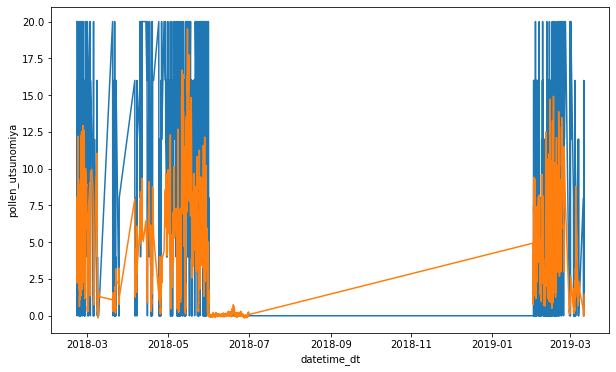

=====fold 1=======
train shape (8160, 1703) test shape (4080, 1703)


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


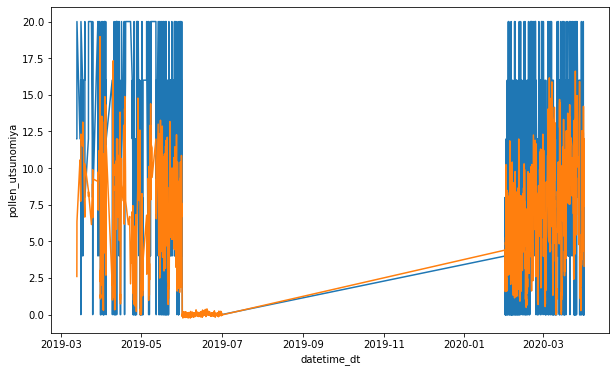

 fold_0 mae: 3.2347644758881886
 fold_1 mae: 3.325096157680398
mean 3.2799303167842933


In [21]:
#utsunomiya_prediction, scores, df_imps = train_lightgbm_with_split_by_year(
#    _df, _df_test, target_label="pollen_utsunomiya", plot=True
#)

#utsunomiya_prediction, scores, df_imps = train_lightgbm_with_cv(
#    _df, _df_test, target_label="pollen_utsunomiya", plot=True
#)

utsunomiya_prediction, scores, df_imps = train_lightgbm_with_cv_log(
    _df, _df_test, target_label="pollen_utsunomiya", plot=True
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean {np.mean(scores)}")

utsunomiya_score = np.mean(scores)

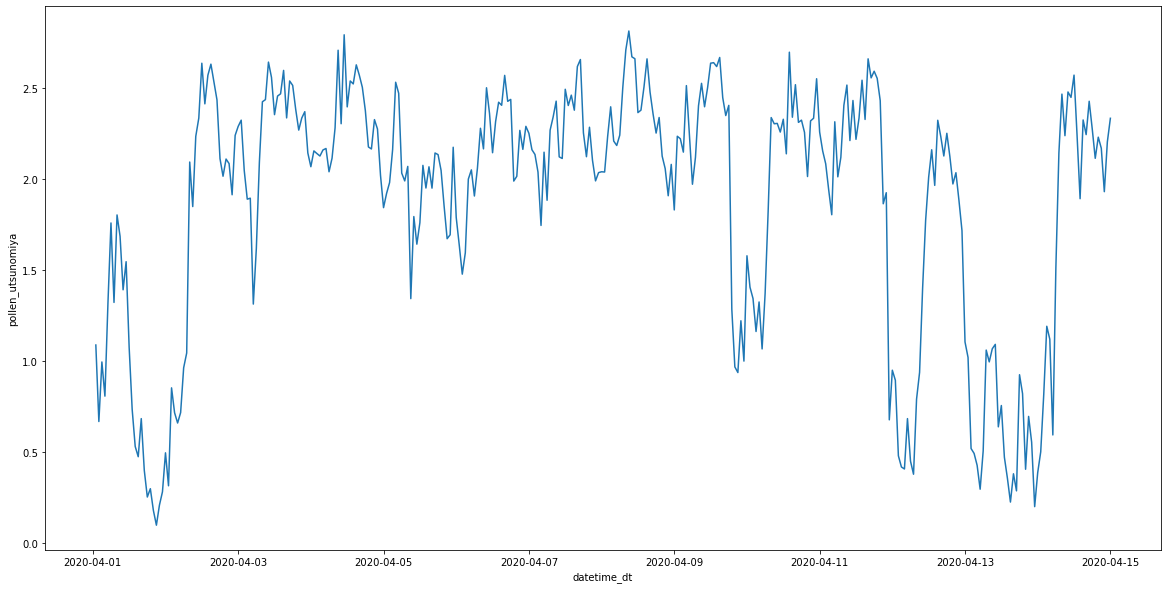

In [22]:
__df_test = _df_test.copy()
__df_test["pollen_utsunomiya"] = utsunomiya_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_utsunomiya")



<AxesSubplot:xlabel='feat_imp', ylabel='columns'>

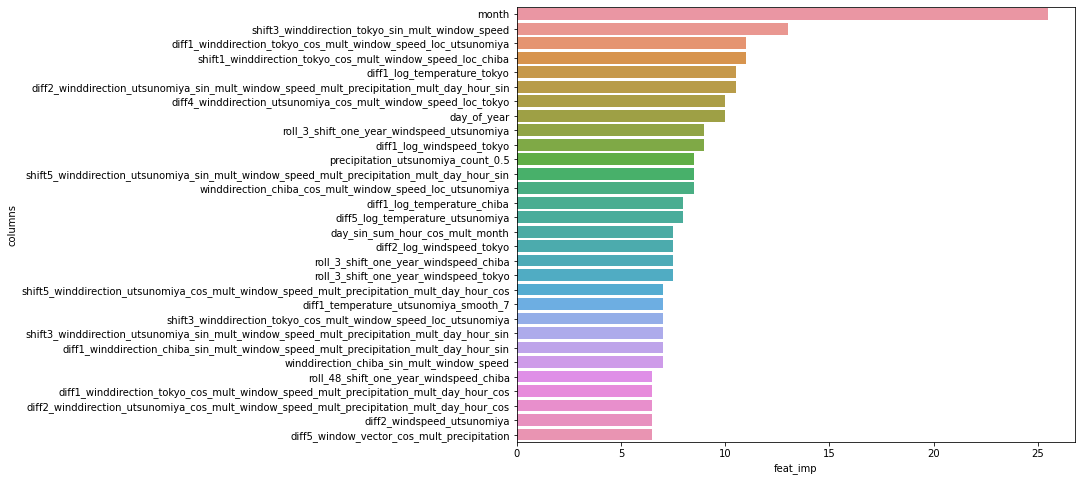

In [23]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


# tokyo

=========pollen_tokyo==========
qth = 8
=====fold 0=======
train shape (4080, 1703) test shape (4080, 1703)


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


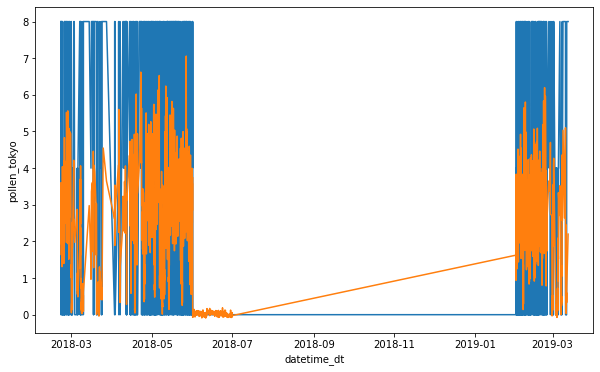

=====fold 1=======
train shape (8160, 1703) test shape (4080, 1703)


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


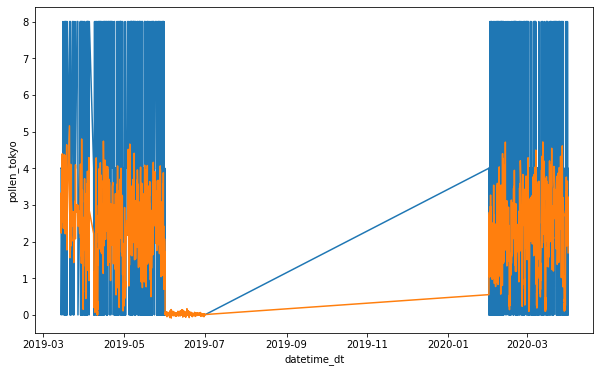

 fold_0 mae: 1.6575881568286643
 fold_1 mae: 1.8329783846077616
mean: 1.7452832707182129


In [24]:
#tokyo_prediction, scores, df_imps = train_lightgbm_with_split_by_year(
#     _df, _df_test, target_label="pollen_tokyo", plot=True
#)

#tokyo_prediction, scores, df_imps = train_lightgbm_with_cv(
#     _df, _df_test, target_label="pollen_tokyo", plot=True, qth=8
#)


tokyo_prediction, scores, df_imps = train_lightgbm_with_cv_log(
     _df, _df_test, target_label="pollen_tokyo", plot=True, qth=8
)

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")

tokyo_score = np.mean(scores)


<AxesSubplot:xlabel='feat_imp', ylabel='columns'>

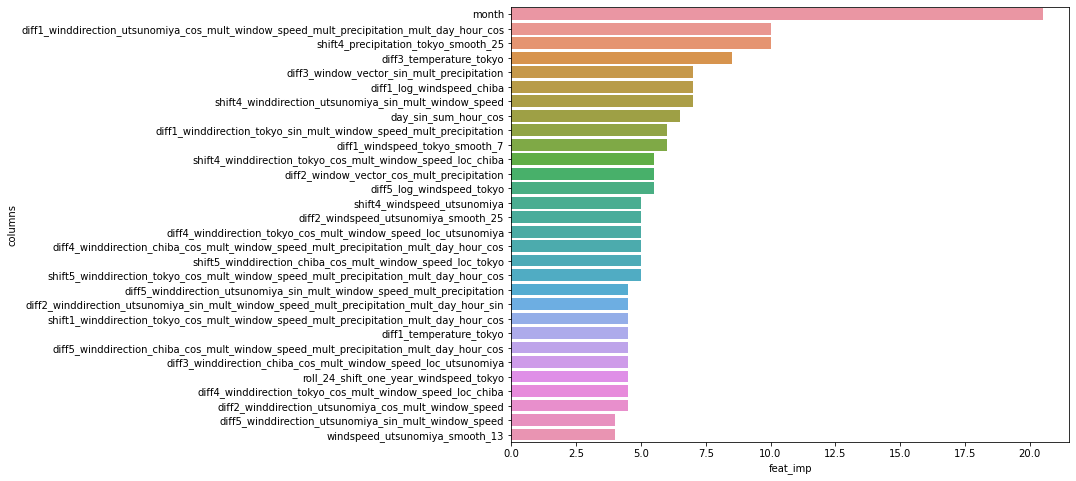

In [25]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


# chiba

=========pollen_chiba==========
qth = 20
=====fold 0=======
train shape (4080, 1703) test shape (4080, 1703)


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


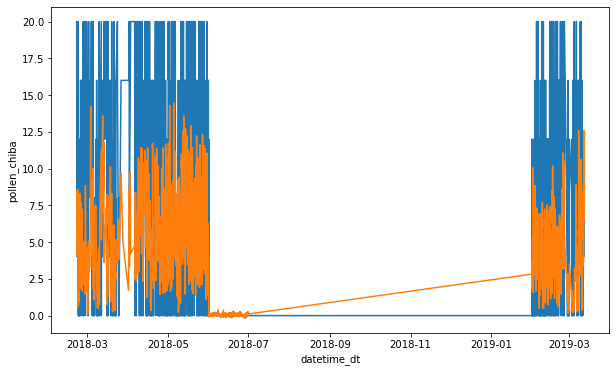

=====fold 1=======
train shape (8160, 1703) test shape (4080, 1703)


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


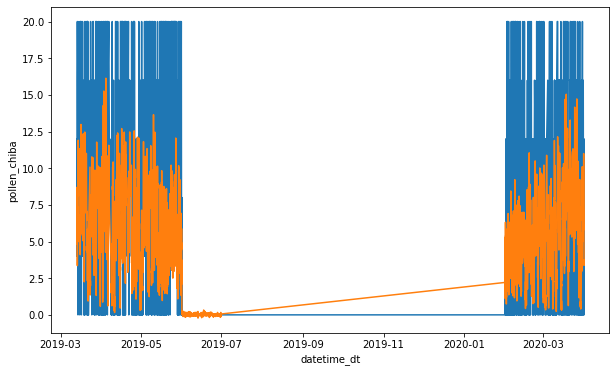

 fold_0 mae: 3.617017743669102
 fold_1 mae: 3.848690585772257
mean: 3.7328541647206794


In [26]:
#chiba_prediction, scores, df_imps = train_lightgbm_with_cv(
#    _df, _df_test, target_label="pollen_chiba", plot=True, 
#)

chiba_prediction, scores, df_imps = train_lightgbm_with_cv_log(
    _df, _df_test, target_label="pollen_chiba", plot=True, 
)


# chiba_prediction, scores, df_imps = train_lightgbm_with_split_by_year(
#     _df, _df_test, target_label="pollen_chiba", plot=True
# )

for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")


chiba_score = np.mean(scores)


<AxesSubplot:xlabel='feat_imp', ylabel='columns'>

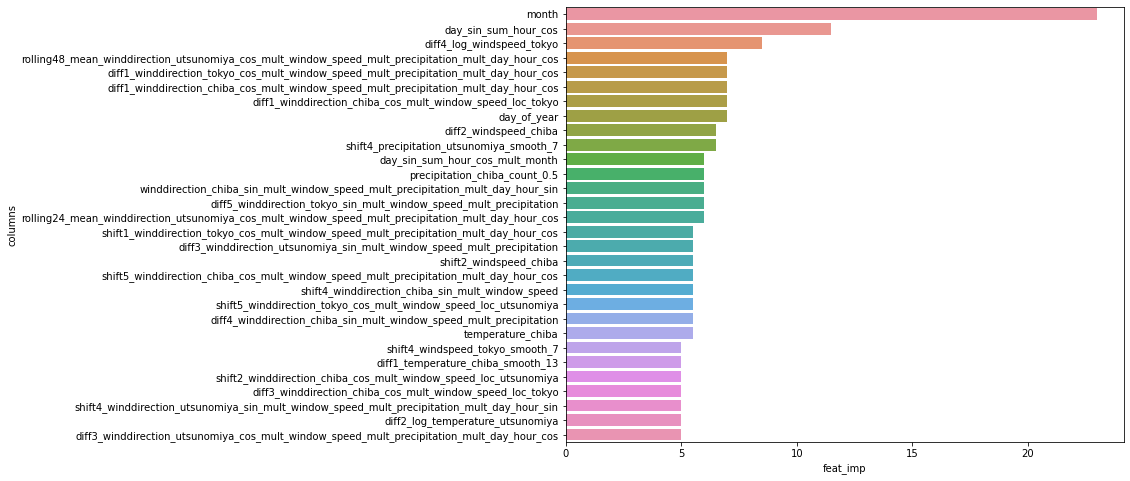

In [27]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


In [28]:
df_imps[df_imps.feat_imp == 0]

,columns,feat_imp
1119,shift3_log_windspeed_chiba,0.0
1120,shift3_log_windspeed_tokyo,0.0
1121,diff3_log_precipitation_utsunomiya,0.0
1122,diff4_precipitation_utsunomiya_smooth_25,0.0
1123,rolling24_mean_temperature_tokyo_smooth_25,0.0
...,...,...
1693,winddirection_tokyo_7,0.0
1694,winddirection_tokyo_6,0.0
1695,winddirection_tokyo_5,0.0
1696,winddirection_tokyo_4,0.0


# submission

In [29]:
df_sub = _df_test[["datetime"]]


In [30]:
df_sub["pollen_utsunomiya"] = utsunomiya_prediction
df_sub["pollen_chiba"] = chiba_prediction
df_sub["pollen_tokyo"] = tokyo_prediction


/tmp/ipykernel_25432/1381866396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["pollen_utsunomiya"] = utsunomiya_prediction
/tmp/ipykernel_25432/1381866396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["pollen_chiba"] = chiba_prediction
/tmp/ipykernel_25432/1381866396.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [31]:
df_sub.head()
df_sub.to_csv(f"sub.csv", index=None)


In [32]:
utsunomiya_score, tokyo_score, chiba_score, np.mean([utsunomiya_score, tokyo_score, chiba_score])

(3.2799303167842933,
 1.7452832707182129,
 3.7328541647206794,
 2.9193559174077284)

# score 

- (3.2799303167842933, 1.7452832707182129, 3.7328541647206794, 2.9193559174077284) ターゲットをlog1pとって戻す　LB: 14.05262
- (3.5686018609333985, 1.8415732355947796, 3.787402864490365, 3.065859320339514)
- (3.5301109446597527, 1.8324352682141685, 3.748121478166283, 3.0368892303467345)

# score
- 64.10566
- 122.26534
- 127.59514
- savgol_filterをラベルに追加: LB: 56.69182, CV: u 126.5, t 36.9, c 28.83
- savgol_filterを特徴量に追加 window size = 35  CV u 124.4, t 36.65, c: 29.22
- savgol_filterを特徴量に変更 window size = 35  (124.40695851120257, 36.659359871522675, 29.1962403298141)
- savgol_filterを特徴量に変更 window size = 35 -> 55  (126.44875318392432, 35.205501763280935, 28.273597737961566, 63.30) 
- 補正値を追加(正解が一定以下のデータのみ学習/検証に使う)　(3.8934261501532745, 4.310516372229987, 28.273597737961566, 12.159180086781609)　LB: 32.22890
- 補正値設定ミスってたので修正 (3.8934261501532745, 2.0175388500923255, 4.304978657590222, 3.405314552611941) LB: 13.95514

- 千葉だけ_cvじゃなかったので修正 (3.8934261501532745, 2.0175388500923255, 4.137336230149423, 3.3494337434650077) LB:13.56184
    - ちなみに split_by_yearは14.34389でしたのでtime_series_cvのほうが良さそう。
    - くわえて、CVとは一応相関してそう

- 風向のone-hotを追加 (3.8906922262087886, 2.017560176147346, 4.138983768571907, 3.3490787236426804)
- roll 36, 48を追加 (3.904820557208936, 2.00576047365233, 4.164051128419937, 3.3582107197604008) -> 下がったので不採用
- ノイズ除去で元のやつも残すように変更、(3.916733830559269, 1.9956051999047397, 4.0699312564943355, 3.327423428986115)
- savgol_filterを特徴量に変更 window size = 55 -> 25 (3.884649061928195, 1.9879375591978263, 4.0603229971309815, 3.3109698727523345)
- savgol_filterを特徴量に追加 window size = 25, 13を新規追加 (3.8754100405526666, 1.984153386413598, 4.065806808103186, 3.3084567450231503)
- savgol_filterを特徴量に追加 window size = 25, 13, 7を新規追加 (3.8819300003928845, 1.9858853018847262, 4.050534532597559, 3.306116611625056)
- labelへのsavgol_filterのwindow sizeを25-> 13に変更  (3.883470658393416, 2.004070969620379, 4.064861992348034, 3.3174678734539427) わるくなったので不採用
- labelへのsavgol_filterのwindow sizeを25-> 37に変更  (3.906864140705683, 1.9963961518020925, 4.111649135182413, 3.338303142563396) わるくなったので不採用
- window speed * window direct cos/sinを追加 (3.8771389594171985, 1.9850645688206736, 4.05984027848512, 3.307347935574331)
- window speed * window direct cos/sin / 降水量 を追加　(3.877556773607786, 1.9875229054957329, 4.042222950328732, 3.3024342098107504)
- smooth の roll を追加 (3.9122461555568577, 1.9667051031784824, 4.085230575131414, 3.321393944622251) LB 13.61288 東京は下がったが、他の地域はあがってしまった。　地域ごとに特徴量を変えた方がいいかもしれない。 

- 3県の地理関係を追加 (3.9284410101986476, 1.9647714009055983, 4.068930186186604, 3.3207141990969498)
- 3県の地理関係のrollを追加 (3.910972561302266, 1.9773775759843935, 4.062062235369705, 3.316804124218788) LB:13.65122
- data_v2に変更。目的変数が負のものは削除 (3.48332439150602, 1.827334834283675, 3.7730654662311234, 3.0279082306736065) LB: 13.11687 
- 地理関係のrollがcos だけだったので、sinも追加　(3.4847560761408323, 1.8298810762884554, 3.805017383126936, 3.039884845185408)
- 雨の日カウント (3.4788018301803905, 1.8225884153507086, 3.834963170677646, 3.0454511387362486) LB: 13.11894
- 未来の降水量rollingを追加 (3.499786823304113, 1.8271401025293814, 3.843773306837279, 3.0569000775569246) 下がったのでなし
- hour sin など追加 (3.494998026616688, 1.8284509473076827, 3.829350742186947, 3.0509332387037724)
- 花粉量　が負のものを削除するタイミングを変更 (3.4895865592870807, 1.8187152052850701, 3.7714009803536515, 3.026567581641934)
- 雨の日カウントの閾値をいくつか追加 & バグ修正 (3.527176287420719, 1.8284351316464935, 3.773244611862589, 3.042952010309934)
- ↑が悪かったので、雨の日カウントを元に戻す　(3.532282349492136, 1.8281523182245236, 3.746280749771424, 3.035571805829361)
- 推論結果が0未満は0に戻す処理 (3.5548989394851898, 1.811832580423297, 3.7572176735127694, 3.041316397807085) LB: 13.10737
- 0未満は欠損とする処理 (3.5826122113664804, 1.850622105641865, 3.821742822223161, 3.0849923797438357) ⇒悪化したので不採用
- 0未満は0とする処理 (3.551210204759732, 1.8049350152106842, 3.7886812051377614, 3.0482754750360592)
- 雪は0,黄砂は欠測 (3.552175861270195, 1.8097301059130684, 3.801985758185241, 3.0546305751228346) => 若干悪化したのでやめ
- 雪0 黄砂0 その他はやめる。 (3.5783321710057914, 1.8033821669320427, 3.807494087788279, 3.0630694752420378)
- label のsavgol filter をはずす (3.515464230028208, 1.820948269659573, 3.768825301543104, 3.0350792670769615) LB: 12.89898